In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from tqdm import tqdm
from dace_query.astrometry import Astrometry
from dace_query.spectroscopy import Spectroscopy
from kepmodel import astrorv, rv, astro
from dace_query import astrometry as astro_dace
from spleaf import term
from copy import deepcopy
from kepmodel.rv import RvModel
from spleaf.term import Error, Jitter, InstrumentJitter
from spleaf.cov import Cov


2025-04-21 17:18:47,485 - WARNING - File .dacerc not found. You are requesting data in public mode. To change this behaviour, create a .dacerc file in your home directory and fill it with your API key. More infos on https://dace.unige.ch


In [2]:
# ==== 1. Load data ====

# CORALIE spectroscopy data
coralie_df = pd.read_csv("complete_coralie_data.csv")

# HIPPARCOS astrometry data
hipparcos_df = pd.read_csv("filtered_hipparcos.csv")

# HD ↔ HIP mapping dictionary
with open("hd_hip_mapping.txt", "r") as f:
    hd_hip_map = ast.literal_eval(f.read())

# Clean mapping
hd_to_hip = {}
for hd, hip in hd_hip_map.items():
    if hip and hip.startswith("HIP") and hd.startswith("HD"):
        try:
            hd_num = int(hd[2:])
            hip_num = int(hip[4:])
            hd_to_hip[hd_num] = hip_num
        except:
            continue


/var/folders/cb/dq7rbdjs1gbbgm7jgswln58m0000gn/T/ipykernel_96309/838678062.py:4: DtypeWarning: Columns (4,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  coralie_df = pd.read_csv("complete_coralie_data.csv")


In [3]:
# 2. Extract unique HD stars from CORALIE dataset
coralie_df["hd_number"] = coralie_df["obj_id_catname"].str.extract(r"HD(\d+)", expand=False).astype(float)
unique_hd_stars = coralie_df["hd_number"].dropna().unique()

In [4]:
hd = 225155
hip = 305

# Sort and extract relevant data
astro_data = hipparcos_df[hipparcos_df["HIP"] == hip].sort_values("T_BJD").reset_index(drop=True)
rv_data = coralie_df[coralie_df["hd_number"] == hd].sort_values("obj_date_bjd").reset_index(drop=True)


In [5]:
amp = "as"
ms = 1.0  # solar masses
epoch_rjd = 50000
epoch_bjd = 2400000
default_hip_jitter = 0.0
default_inst_jitter = {"CORALIE98": 5.0, "CORALIE07": 8.0}


In [6]:
from spleaf import term
from kepmodel import astro, rv, astrorv

t_ast = astro_data["T_BJD"].values - epoch_bjd

astro_model = astro.AstroModel(
    t_ast,
    astro_data["S_MAS"].values,
    astro_data["CTH"].values,
    astro_data["STH"].values,
    err=term.Error(astro_data["SRES"].values),
    jit=term.Jitter(default_hip_jitter),
)

dt_yr = (astro_data["T_BJD"] - epoch_bjd) / 365.25
astro_model.add_lin(astro_data["PARF"], "plx")
astro_model.add_lin(astro_data["CTH"], "delta")
astro_model.add_lin(astro_data["STH"], "alpha")
astro_model.add_lin(dt_yr * astro_data["CTH"], "mud")
astro_model.add_lin(dt_yr * astro_data["STH"], "mua")

astro_model.fit()
astro_model.show_param()
print(f"Astrometry loglikelihood: {astro_model.loglike():.3f}")


Parameter                        Value     Error       
lin.plx                         0.4858  ±  0.0319      
lin.delta                        15.02  ±  3.01        
lin.alpha                        59.83  ±  4.48        
lin.mud                        -0.1141  ±  0.0228      
lin.mua                        -0.4519  ±  0.0338      
Astrometry loglikelihood: -397716.472


In [9]:
import pandas as pd
import numpy as np
from kepmodel import astro, rv, astrorv
from spleaf import term

# === STEP 1: Select star ===
hd = 225155
hip = 305

# === STEP 2: Extract data ===
astro_data = hipparcos_df[hipparcos_df["HIP"] == hip].sort_values("T_BJD").reset_index(drop=True)
rv_data = coralie_df[coralie_df["hd_number"] == hd].sort_values("obj_date_bjd").reset_index(drop=True)

# === STEP 3: Set constants ===
epoch_rjd = 50000
epoch_bjd = 2400000

default_hip_jitter = 0.0
default_inst_jitter = {
    "CORALIE98": 5.0,
    "CORALIE07": 8.0
}

# === STEP 4: Fit astrometric model ===
t_ast = astro_data["T_BJD"].values - epoch_bjd
astro_model = astro.AstroModel(
    t_ast,
    astro_data["S_MAS"].values,
    astro_data["CTH"].values,
    astro_data["STH"].values,
    err=term.Error(astro_data["SRES"].values),
    jit=term.Jitter(default_hip_jitter),
)

dt_yr = (astro_data["T_BJD"] - epoch_bjd) / 365.25
astro_model.add_lin(astro_data["PARF"], "plx")
astro_model.add_lin(astro_data["CTH"], "delta")
astro_model.add_lin(astro_data["STH"], "alpha")
astro_model.add_lin(dt_yr * astro_data["CTH"], "mud")
astro_model.add_lin(dt_yr * astro_data["STH"], "mua")

astro_model.fit()
astro_model.show_param()
print(f"Astrometry loglikelihood: {astro_model.loglike():.3f}")

# === STEP 5: Fit RV model ===
t_rv = rv_data["obj_date_bjd"].values - epoch_rjd
v_rv = rv_data["spectro_ccf_rv"].values
rv_err = rv_data["spectro_ccf_rv_err"].values

instruments = ["CORALIE98", "CORALIE07"]
instjit = {
    f"jit_{inst}": term.InstrumentJitter(
        rv_data["ins_name"].values == inst,
        default_inst_jitter[inst]
    ) for inst in instruments
}

# ✅ Using required format
rv_model = rv.RvModel(
    t_rv,
    v_rv,
    err=term.Error(rv_err),
    **instjit
)

for inst in instruments:
    rv_model.add_lin((rv_data["ins_name"] == inst).astype(float), f"offset_{inst}")

rv_model.fit()
rv_model.show_param()
print(f"RV loglikelihood: {rv_model.loglike():.3f}")

# === STEP 6: Combine models ===
full_model = astrorv.AstroRvModel(astro_model, rv_model)
full_model.fit()
full_model.fit()
full_model.fit()

full_model.show_param()
print(f"Combined model loglikelihood: {full_model.loglike():.3f}")


Parameter                        Value     Error       
lin.plx                         0.4858  ±  0.0319      
lin.delta                        15.02  ±  3.01        
lin.alpha                        59.83  ±  4.48        
lin.mud                        -0.1141  ±  0.0228      
lin.mua                        -0.4519  ±  0.0338      
Astrometry loglikelihood: -397716.472
Parameter                        Value     Error       
lin.offset_CORALIE98         -24059.64  ±  1.82        
lin.offset_CORALIE07         -19148.76  ±  8.89        
RV loglikelihood: -999362.343
Parameter                        Value     Error       
astro.lin.plx                   0.4858  ±  0.0319      
astro.lin.delta                  15.02  ±  3.01        
astro.lin.alpha                  59.83  ±  4.48        
astro.lin.mud                  -0.1141  ±  0.0228      
astro.lin.mua                  -0.4519  ±  0.0338      
rv.lin.offset_CORALIE98      -24059.64  ±  1.82        
rv.lin.offset_CORALIE07      -19148.

/Users/Patron/Desktop/code/CS539/Exoplanet-Detection-CS539-Project/exo/lib/python3.12/site-packages/kepmodel/astrorv.py:32: UserWarning: AstroRvModel cannot use angular keplerian parameters,
switching AstroModel to use physical keplerian parameters
  warnings.warn(


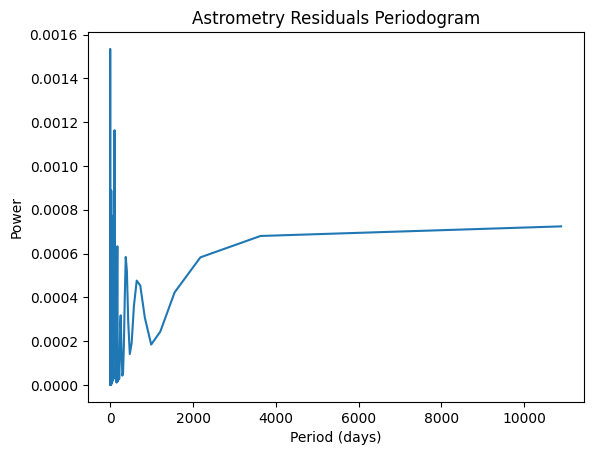

In [11]:
from astropy.timeseries import LombScargle

# === Astrometry Periodogram ===
astro_resid = astro_model.residuals()
astro_time = t_ast  # use the original time array

astro_freq, astro_power = LombScargle(astro_time, astro_resid).autopower()
plt.plot(1 / astro_freq, astro_power)
plt.xlabel("Period (days)")
plt.ylabel("Power")
plt.title("Astrometry Residuals Periodogram")
plt.show()



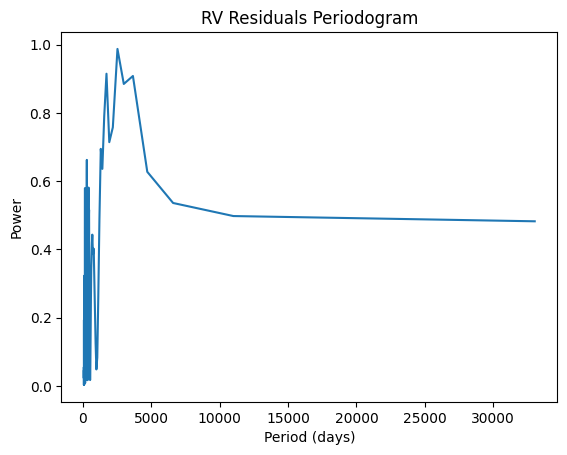

In [12]:
# === RV Periodogram ===
rv_resid = rv_model.residuals()
rv_time = t_rv  # use original RV time array

rv_freq, rv_power = LombScargle(rv_time, rv_resid).autopower()
plt.plot(1 / rv_freq, rv_power)
plt.xlabel("Period (days)")
plt.ylabel("Power")
plt.title("RV Residuals Periodogram")
plt.show()


In [1]:
from tqdm import tqdm
from kepmodel import astro, rv, astrorv
from spleaf import term
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ast

# === Load data ===
print("Loading data...")
coralie_df = pd.read_csv("complete_coralie_data.csv")
hipparcos_df = pd.read_csv("filtered_hipparcos.csv")

with open("hd_hip_mapping.txt", "r") as f:
    hd_hip_map = ast.literal_eval(f.read())

# Clean mapping
hd_to_hip = {}
for hd, hip in hd_hip_map.items():
    if hip and hip.startswith("HIP") and hd.startswith("HD"):
        try:
            hd_num = int(hd[2:])
            hip_num = int(hip[4:])
            hd_to_hip[hd_num] = hip_num
        except:
            continue

coralie_df["hd_number"] = coralie_df["obj_id_catname"].str.extract(r"HD(\d+)", expand=False).astype(float)
unique_hd_stars = coralie_df["hd_number"].dropna().unique()

# === Constants ===
epoch_rjd = 50000
epoch_bjd = 2400000
default_hip_jitter = 0.0
default_inst_jitter = {"CORALIE98": 5.0, "CORALIE07": 8.0}
instruments = ["CORALIE98", "CORALIE07"]

# === Periodogram settings ===
Pmin = 0.9
Pmax = 50000
nfreq = 5000  # Reduced to prevent crash
nu0 = 2 * np.pi / Pmax
dnu = (2 * np.pi / Pmin - nu0) / (nfreq - 1)

print(f"Processing {len(unique_hd_stars)} stars...")

# === Process each star ===
for hd in tqdm(unique_hd_stars):
    if hd not in hd_to_hip:
        print(f"Skipping HD {int(hd)} — no HIP match.")
        continue
    hip = hd_to_hip[hd]

    print(f"\n=== Processing HD {int(hd)} / HIP {hip} ===")

    astro_data = hipparcos_df[hipparcos_df["HIP"] == hip].sort_values("T_BJD")
    rv_data = coralie_df[coralie_df["hd_number"] == hd].sort_values("obj_date_bjd")

    if len(astro_data) < 5 or len(rv_data) < 5:
        print(f"Skipping HD {int(hd)} — not enough data.")
        continue

    try:
        # --- Astrometry Model ---
        print("  Fitting astrometry model...")
        t_ast = astro_data["T_BJD"].values - epoch_bjd
        astro_model = astro.AstroModel(
            t_ast,
            astro_data["S_MAS"].values,
            astro_data["CTH"].values,
            astro_data["STH"].values,
            err=term.Error(astro_data["SRES"].values),
            jit=term.Jitter(default_hip_jitter),
        )

        dt_yr = (astro_data["T_BJD"] - epoch_bjd) / 365.25
        astro_model.add_lin(astro_data["PARF"], "plx")
        astro_model.add_lin(astro_data["CTH"], "delta")
        astro_model.add_lin(astro_data["STH"], "alpha")
        astro_model.add_lin(dt_yr * astro_data["CTH"], "mud")
        astro_model.add_lin(dt_yr * astro_data["STH"], "mua")
        astro_model.fit()
        print("    ✔ Astrometry model fitted.")

        # --- RV Model ---
        print("  Fitting RV model...")
        t_rv = rv_data["obj_date_bjd"].values - epoch_rjd
        v_rv = rv_data["spectro_ccf_rv"].values
        rv_err = rv_data["spectro_ccf_rv_err"].values

        instjit = {
            f"jit_{inst}": term.InstrumentJitter(
                rv_data["ins_name"].values == inst,
                default_inst_jitter[inst]
            ) for inst in instruments
        }

        rv_model = rv.RvModel(t_rv, v_rv, err=term.Error(rv_err), **instjit)
        for inst in instruments:
            rv_model.add_lin((rv_data["ins_name"] == inst).astype(float), f"offset_{inst}")
        rv_model.fit()
        print("    ✔ RV model fitted.")

        # --- Joint Model ---
        print("  Fitting joint (astro+RV) model...")
        full_model = astrorv.AstroRvModel(astro_model, rv_model)
        full_model.fit(); full_model.fit(); full_model.fit()
        print("    ✔ Joint model fitted.")

        # --- Periodograms ---
        print("  Computing and displaying periodograms...")
        models = [astro_model, rv_model, full_model]
        model_names = ["Astrometry", "RV", "Joint"]
        fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 8))

        for i, model in enumerate(models):
            ax = axs[i]
            try:
                nu, power = model.periodogram(nu0, dnu, nfreq)
                P = 2 * np.pi / nu
                max_power_idx = np.argmax(power)
                peak_period = P[max_power_idx]
                fap = model.fap(power[max_power_idx], nu.max())

                ax.plot(P, power, lw=1)
                ax.plot(peak_period, power[max_power_idx], "or")
                ax.set_xscale("log")
                ax.set_ylabel("Power")
                ax.set_title(f"{model_names[i]}: {peak_period:.1f} d (FAP={fap:.2g})")
            except Exception as e:
                ax.text(0.5, 0.5, f"Periodogram failed: {e}", transform=ax.transAxes,
                        ha="center", va="center", color="red")
                print(f"    ✖ Periodogram failed for {model_names[i]}: {e}")

        axs[-1].set_xlabel("Period (days)")
        plt.tight_layout()
        plt.suptitle(f"HD {int(hd)} / HIP {hip}", fontsize=14, y=1.02)
        plt.show()

    except Exception as e:
        print(f"    ✖ Error with HD {int(hd)}: {e}")
        continue

print("\n✅ Finished processing all stars.")


/var/folders/cb/dq7rbdjs1gbbgm7jgswln58m0000gn/T/ipykernel_96650/2656668634.py:11: DtypeWarning: Columns (4,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  coralie_df = pd.read_csv("complete_coralie_data.csv")


Loading data...
Processing 250 stars...


  0%|          | 0/250 [00:00<?, ?it/s]


=== Processing HD 175518 / HIP 92918 ===
Skipping HD 175518 — not enough data.

=== Processing HD 13445 / HIP 10138 ===
Skipping HD 13445 — not enough data.

=== Processing HD 219709 / HIP 115087 ===
Skipping HD 219709 — not enough data.

=== Processing HD 1926 / HIP 1823 ===
Skipping HD 1926 — not enough data.

=== Processing HD 202457 / HIP 105214 ===
Skipping HD 202457 — not enough data.

=== Processing HD 3222 / HIP 2743 ===
Skipping HD 3222 — not enough data.

=== Processing HD 17289 / HIP 12726 ===
Skipping HD 17289 — not enough data.

=== Processing HD 10647 / HIP 7978 ===
Skipping HD 10647 — not enough data.

=== Processing HD 31143 / HIP 22602 ===
Skipping HD 31143 — not enough data.

=== Processing HD 20916 / HIP 15539 ===
Skipping HD 20916 — not enough data.

=== Processing HD 39091 / HIP 26394 ===
Skipping HD 39091 — not enough data.

=== Processing HD 40307 / HIP 27887 ===
Skipping HD 40307 — not enough data.

=== Processing HD 30501 / HIP 22122 ===
Skipping HD 30501 — no

/Users/Patron/Desktop/code/CS539/Exoplanet-Detection-CS539-Project/exo/lib/python3.12/site-packages/kepmodel/astrorv.py:32: UserWarning: AstroRvModel cannot use angular keplerian parameters,
switching AstroModel to use physical keplerian parameters
  warnings.warn(


Skipping HD 149414 — not enough data.

=== Processing HD 158783 / HIP 85969 ===
Skipping HD 158783 — not enough data.

=== Processing HD 162255 / HIP 87370 ===
Skipping HD 162255 — not enough data.

=== Processing HD 169586 / HIP 90397 ===
Skipping HD 169586 — not enough data.

=== Processing HD 171999 / HIP 91360 ===
Skipping HD 171999 — not enough data.

=== Processing HD 173397 / HIP 92342 ===
Skipping HD 173397 — not enough data.

=== Processing HD 175073 / HIP 92858 ===
Skipping HD 175073 — not enough data.

=== Processing HD 209779 / HIP 109110 ===
Skipping HD 209779 — not enough data.

=== Processing HD 212330 / HIP 110649 ===
Skipping HD 212330 — not enough data.

=== Processing HD 218483 / HIP 114286 ===
Skipping HD 218483 — not enough data.

=== Processing HD 217580 / HIP 113718 ===
Skipping HD 217580 — not enough data.

=== Processing HD 1815 / HIP 1768 ===
Skipping HD 1815 — not enough data.

=== Processing HD 3277 / HIP 2790 ===
Skipping HD 3277 — not enough data.

=== Pro

: 

In [3]:
import pandas as pd
import ast

# === Load files ===
coralie_df = pd.read_csv("complete_coralie_data.csv")
hipparcos_df = pd.read_csv("filtered_hipparcos.csv")

with open("hd_hip_mapping.txt", "r") as f:
    hd_hip_map = ast.literal_eval(f.read())

# === Extract HD number from CORALIE data ===
coralie_df["hd_number"] = coralie_df["obj_id_catname"].str.extract(r"HD(\d+)", expand=False).astype(float)

# === Clean up HD-HIP mapping ===
hd_to_hip = {}
for hd, hip in hd_hip_map.items():
    if hip and hip.startswith("HIP") and hd.startswith("HD"):
        try:
            hd_num = int(hd[2:])
            hip_num = int(hip[4:])
            hd_to_hip[hd_num] = hip_num
        except:
            continue

# === Identify usable stars ===
valid_entries = []

for hd in coralie_df["hd_number"].dropna().unique():
    if hd not in hd_to_hip:
        continue

    hip = hd_to_hip[hd]
    rv_data = coralie_df[coralie_df["hd_number"] == hd]
    astro_data = hipparcos_df[hipparcos_df["HIP"] == hip]

    if len(rv_data) >= 1 and len(astro_data) >= 1:
        for _, rv_row in rv_data.iterrows():
            valid_entries.append({
                "HD": int(hd),
                "HIP": hip,
                **rv_row.to_dict()
            })

# === Create and save CSV ===
usable_df = pd.DataFrame(valid_entries)
usable_df.to_csv("usable_star_data_combined.csv", index=False)
print(f"✅ Saved usable star data for {usable_df['HD'].nunique()} stars to 'usable_star_data_combined.csv'")


✅ Saved usable star data for 1 stars to 'usable_star_data_combined.csv'


/var/folders/cb/dq7rbdjs1gbbgm7jgswln58m0000gn/T/ipykernel_96876/1490089717.py:5: DtypeWarning: Columns (4,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  coralie_df = pd.read_csv("complete_coralie_data.csv")
